Library

In [2]:
import cv2      
import tensorflow as tf  
from keras.preprocessing.image import ImageDataGenerator  
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Dropout,Conv2D ,MaxPool2D,Flatten 
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam 

In [14]:


def segmentation(frame, threshold=50): 

    global background  
    difference = cv2.absdiff(background.astype("uint8"), frame)
    _, processed_frame = cv2.threshold(difference, threshold, 255, cv2.THRESH_BINARY)
    contoure,_=cv2.findContours(processed_frame,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(contoure)==0:
        return None
    else:
        contoure=max(contoure,key=cv2.contourArea)
    return (processed_frame,contoure)

Generate dataset

In [17]:
cam=cv2.VideoCapture(0)
top=50
left=250
right=50
bottom=300
digit=0
background=None
count=0
sample_num=0 
model2=tf.keras.models.load_model('C:\\Users\\asus\\Desktop\\cv\\model.h5')

while True:
   value, frame= cam.read()
   framecopy=frame.copy()
   framecopy=cv2.flip(framecopy,1)
   roi=framecopy[top:bottom,right:left]
   roi_gray=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
   roi_gray=cv2.GaussianBlur(roi_gray,(9,9),0)
   if background is None:
       background=roi_gray.copy().astype("float")
       
   
   cv2.rectangle(framecopy,(left,top),(right,bottom),(0,0,255),3)
   if count<30:
      cv2.accumulateWeighted(roi_gray,background,0.5)
      cv2.putText(framecopy,"Loading....",(280,200),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),3)
   collection=segmentation(roi_gray) 
   k=cv2.waitKey(1)
   
   if collection is not None:
      roi_processed,contoure= collection
      cv2.drawContours(framecopy,[contoure+(right,top)],-1,(0,255,0),3) 

      roi_processed=cv2.resize(roi_processed,(64,64))
      roi_processed=cv2.cvtColor(roi_processed,cv2.COLOR_GRAY2RGB)
      frame=np.reshape(roi_processed,(1,roi_processed.shape[0],roi_processed.shape[1],3))
      value=model2.predict(frame)
      lable=words[np.argmax(value)]
      cv2.putText(framecopy,str(lable),(370,145),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)
        
      
      if k==ord("t"):
         
         cv2.putText(framecopy,str(sample_num)+ "gesture("+str(digit)+" )",(70,45),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
         sample_num+=1
         cv2.imwrite("C:\\Users\\asus\\Desktop\\cv\\gesture\\train\\"+str(digit)+"\\"+str(digit)+"_"+str(sample_num)+".jpg", roi_processed)
      elif k==ord("s"):    
      
         cv2.putText(framecopy,str(sample_num)+ "gesture("+str(digit)+" )",(70,45),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
         sample_num+=1
         cv2.imwrite("C:\\Users\\asus\\Desktop\\cv\\gesture\\test\\"+str(digit)+"\\"+str(digit)+"_"+str(sample_num)+".jpg", roi_processed)
      cv2.imshow("sigmentation",roi_processed)
      
   cv2.putText(framecopy,"Gesture(" +str(digit)+ ")",(60,350),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
   cv2.imshow("camrea",framecopy)   
   count+=1
   if k==27: 
       break
   elif k==13: 
      digit=(digit+1)%5
      sample_num=0
cv2.destroyAllWindows()   
cam.release()

1/1 [==============================] - 0s 36ms/step


In [5]:

train_data_path="C:\\Users\\asus\\Desktop\\cv\\gesture\\train"

train_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_data_path,target_size=(64,64),class_mode="categorical",batch_size=5,shuffle=True)
test_data_path="C:\\Users\\asus\\Desktop\\cv\\gesture\\test"
test_data_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_data_path,target_size=(64,64),class_mode="categorical",batch_size=5,shuffle=True)
images_train, labels_train = next(train_data_batches)
images_test, labels_test = next(test_data_batches)



Found 186 images belonging to 5 classes.
Found 140 images belonging to 5 classes.


In [6]:
def display(images):
    fig,axis=plt.subplots(1,5,figsize=(30,20))
    for image,ax in zip(images,axis):
        image=np.clip(image,0,1)
        ax.imshow(image)
        ax.axis("off")
    plt.tight_layout
    plt.show() 
  

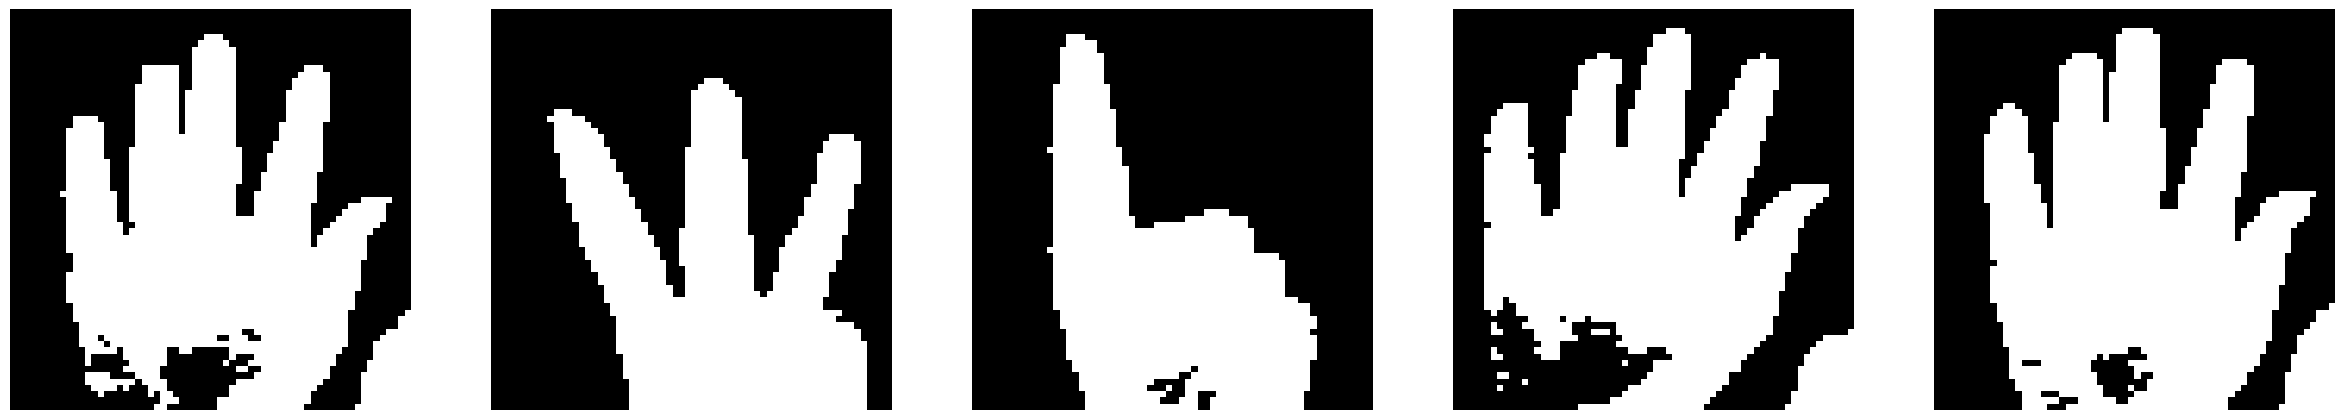

five           three           one           five           five           

In [7]:
display(images_train)   
words={0:'one',1:'tow',2:'three',3:'four',4:'five'}
def digit(labels):
    for label in labels:
        print(words[np.argmax(label)],end="           ")
digit(labels_train)        

In [8]:
def createModel():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(64,64,3)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    return model
model=createModel() 
model.summary()
    
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

training

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


In [10]:
model.fit(train_data_batches,epochs=7,validation_data=test_data_batches)

Epoch 1/7


38/38 [==============================] - 6s 55ms/step - loss: 5.6355 - accuracy: 0.3602 - val_loss: 1.1006 - val_accuracy: 0.4786
Epoch 2/7
38/38 [==============================] - 1s 36ms/step - loss: 0.9451 - accuracy: 0.6344 - val_loss: 0.7880 - val_accuracy: 0.7643
Epoch 3/7
38/38 [==============================] - 1s 38ms/step - loss: 0.3010 - accuracy: 0.9032 - val_loss: 0.9359 - val_accuracy: 0.7071
Epoch 4/7
38/38 [==============================] - 3s 65ms/step - loss: 0.0664 - accuracy: 0.9892 - val_loss: 1.2369 - val_accuracy: 0.6857
Epoch 5/7
38/38 [==============================] - 2s 50ms/step - loss: 0.2811 - accuracy: 0.9301 - val_loss: 0.6655 - val_accuracy: 0.9000
Epoch 6/7
38/38 [==============================] - 2s 60ms/step - loss: 0.0426 - accuracy: 0.9785 - val_loss: 1.0127 - val_accuracy: 0.8429
Epoch 7/7
38/38 [==============================] - 2s 47ms/step - loss: 0.0157 - accuracy: 0.9946 - val_loss: 1.2309 - val_accuracy: 0.7643


In [11]:
scores=model.evaluate(images_test,labels_test,verbose=0)
scores
print(f'{model.metrics_names[0]}={scores[0]}')
print(f'{model.metrics_names[1]}={scores[1]}')

loss=1.5909768342971802
accuracy=0.800000011920929


In [13]:
model.save('C:\\Users\\asus\\Desktop\\cv\\model.h5')